# Reply Tool AB Test

Instrumentation Notes:

* Reply Tool events: event.action = 'init', event.integration = 'discussiontools', event.init_type = 'page'
* VE/WikiEditor Reply Events: event.action = 'init', event.integration = 'page' , event.init_type = 'section' or 'page', event.init_mechanism = 'click' (Note: this exlsude any edits to create new sections or pages but does not decipher between a reply edit and other non-create edits such as correction edits. 

Data Notes:
- Excluded edits to create new sections
- Data from Feb 25 to March 1 removed error in Sampling Rate change: https://gerrit.wikimedia.org/r/c/mediawiki/extensions/WikimediaEvents/+/667690
- While we can distinguish reply tool edits, the currently available instrumentation does not currently decipher between a correction edit versus a reply edit for Visual Editor/Wikieditor edits on talk pages. For the pusposes of this analysis, we assumed that all Visual Editor/Wikieditor edits to talk pages that were not edits to create new sections or pages were replies.

In [24]:
library(lme4)

ERROR: Error in library(lme4): there is no package called ‘lme4’


In [8]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
     library(tidyverse); library(lubridate)
    library(scales); library(lme4)
})

# Option 1: Edit Attempts By User

In [2]:
# Collect data on talk page edit attempts exluding new section edits

query <-
"
SELECT
    date_format(dt, 'yyyy-MM-dd') AS attempt_dt,
    wiki AS wiki,
    event.user_id AS user_id,
    event.editing_session_id AS edit_attempt_id,
    event.integration AS editor_type, 
    If(event.integration == 'discussiontools', 1, 0) AS enabled,
    If(event.action == 'saveSuccess', 1, 0) AS edit_completed,
    CASE
        WHEN min(event.user_editcount) is NULL THEN 'undefined'
        WHEN min(event.user_editcount) < 100 THEN 'under 100'
        WHEN (min(event.user_editcount) >=100 AND min(event.user_editcount < 500)) THEN '100-499'
        ELSE '500+'
        END AS edit_count
FROM event.editattemptstep
WHERE
    wiki IN ('frwiki', 'eswiki', 'itwiki', 'jawiki', 'fawiki', 'plwiki', 'hewiki', 'nlwiki',
    'hiwiki', 'kowiki', 'viwiki', 'thwiki', 'ptwiki', 'bnwiki', 'arzwiki', 'swwiki', 'zhwiki',
    'ukwiki', 'idwiki', 'amwiki', 'omwiki', 'afwiki')
-- AB test deployed on Feb 11th 
    AND year = 2021 
    AND ((month = 02 AND day >= 12) OR (month > 02))
-- look at only desktop events
    AND event.platform = 'desktop'
-- review all talk namespaces
    AND event.page_ns % 2 = 1
-- only users in AB test
    AND event.bucket IN ('test', 'control')
-- discard VE/Wikiditor edits to create new page or section or new discussion tool edits
    AND NOT ((event.action = 'init' AND (event.init_mechanism = 'url-new' OR event.init_mechanism == 'new'))
    OR (event.action = 'init' AND (event.init_type = 'section' AND event.integration ='discussiontools')))
    -- remove bots
    AND useragent.is_bot = false
    AND event.user_id !=0
GROUP BY
    date_format(dt, 'yyyy-MM-dd'),
    wiki,
    event.user_id,
    event.editing_session_id,
    event.integration,
    If(event.integration == 'discussiontools', 1, 0),
    If(event.action == 'saveSuccess', 1, 0) 
"

In [3]:
collect_ab_edit_attempts <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [4]:
head(collect_ab_edit_attempts)

,attempt_dt,wiki,user_id,edit_attempt_id,editor_type,enabled,edit_completed,edit_count
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,2021-02-12,eswiki,2529480,e42240f303d1467303f0,discussiontools,1,1,under 100
2,2021-02-12,eswiki,5537904,23291ea2c1ebde57a90f,discussiontools,1,0,under 100
3,2021-02-12,eswiki,6134736,5e41ef2e829591f91988,discussiontools,1,0,under 100
4,2021-02-12,eswiki,6135200,ecdf74bd40548780af76,discussiontools,1,0,under 100
5,2021-02-12,eswiki,6135242,67f168e5cc7f23b4cbce,discussiontools,1,1,under 100
6,2021-02-12,eswiki,6135242,d519ab9a42db20a5e5f8,discussiontools,1,0,under 100


In [5]:
# reformat to date format
collect_ab_edit_attempts$attempt_dt <- as.Date(collect_ab_edit_attempts$attempt_dt, format = "%Y-%m-%d")


In [6]:
#set test group factor levels
collect_ab_edit_attempts$editor_type <- factor(collect_ab_edit_attempts$editor_type, levels = c("page", "discussiontools"), labels = c("VE/Wikieditor", "Discussion Tools"))



In [9]:
# remove data from dates where EditAttempt Stemps events were not sampled correctly.

collect_ab_edit_attempts <- collect_ab_edit_attempts %>%
    filter(attempt_dt < '2021-02-25' | attempt_dt > '2021-03-01')

In [10]:
collect_ab_edit_attempts$user_id<- as.character(collect_ab_edit_attempts$user_id) 


## Data Distribution

Note: Edit Completion Rate defined as number of attempts that met saveSuccess. Alternative definition could be the number of users that made at least 1 sucessful edit.

### Edit Completion Rate Defined as Number of Edit Attempts that are saved

In [11]:
# Review edit attempts by event type and wiki
ab_edit_attempts_all <- collect_ab_edit_attempts %>%
    group_by (editor_type) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id),
             completion_rate = round(sum(edit_completed)/n_attempts, 2))

ab_edit_attempts_all

`summarise()` ungrouping output (override with `.groups` argument)



editor_type,n_users,n_attempts,completion_rate
<fct>,<int>,<int>,<dbl>
VE/Wikieditor,2135,4291,0.58
Discussion Tools,1712,3839,0.61


In [12]:
# Review edit attempts by event type and wiki
ab_edit_attempts_bywiki <- collect_ab_edit_attempts %>%
    group_by (wiki, editor_type) %>%
    summarise(n_users = n_distinct(user_id),
              n_attempts = n_distinct(edit_attempt_id),
              completion_rate = round(sum(edit_completed)/n_attempts, 2))

ab_edit_attempts_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,editor_type,n_users,n_attempts,completion_rate
<chr>,<fct>,<int>,<int>,<dbl>
afwiki,VE/Wikieditor,3,5,0.80
afwiki,Discussion Tools,1,4,1.00
arzwiki,VE/Wikieditor,7,8,0.25
arzwiki,Discussion Tools,2,3,0.33
bnwiki,VE/Wikieditor,19,39,0.77
bnwiki,Discussion Tools,12,26,0.69
eswiki,VE/Wikieditor,320,918,0.72
eswiki,Discussion Tools,274,474,0.60
fawiki,VE/Wikieditor,107,174,0.52


In [14]:
options(repr.plot.width = 15, repr.plot.height = 10)

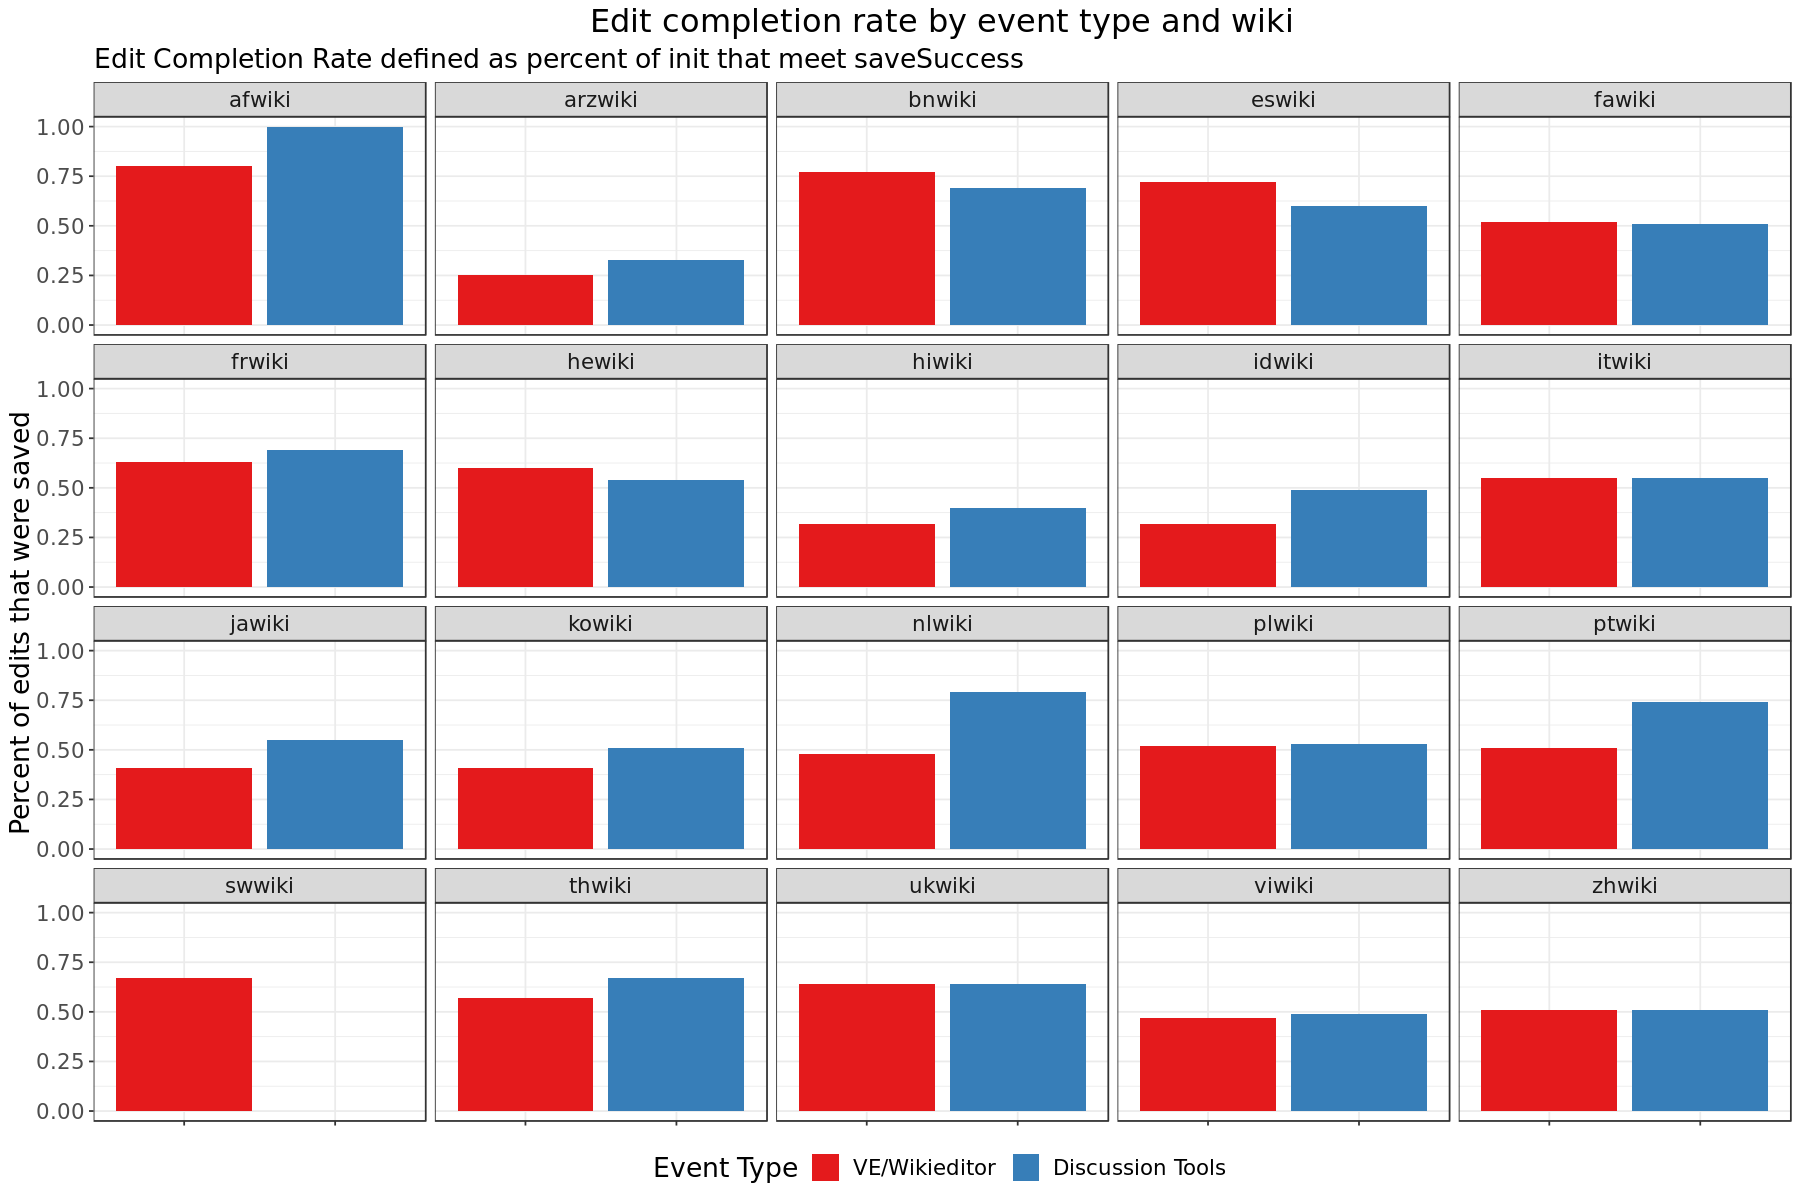

In [15]:
# Plot edit completion rates for each user on each wiki and each 

p <- ab_edit_attempts_bywiki  %>%
    ggplot(aes(x= editor_type, y = completion_rate, fill = editor_type)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki) +
    labs (y = "Percent of edits that were saved ",
          x = "Editor Type",
          title = "Edit completion rate by event type and wiki",
          subtitle = 'Edit Completion Rate defined as percent of init that meet saveSuccess')  +
    theme_bw() +
    scale_fill_brewer(name="Event Type", palette="Set1")  +
    theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        legend.position = "bottom")
      
p

In [16]:
# two-way contingency table of categorical outcome and predictors we want
## to make sure there are not 0 cells
xtabs(~edit_completed + enabled, data = collect_ab_edit_attempts)

              enabled
edit_completed    0    1
             0 4299 3847
             1 2509 2326

### Edit Completion Rate Defined as percent of users that save at least one edit

In [17]:
# Review user edit attempts by event type and wiki

ab_user_completion_rate_all <- collect_ab_edit_attempts %>%
    group_by (editor_type, user_id) %>%
    summarise(n_completions = sum(edit_completed)) %>%
    ungroup() %>%
    group_by(editor_type) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_completed = sum(n_completions >= 1),
             completion_rate = round(n_users_completed/n_users, 2))

ab_user_completion_rate_all

`summarise()` regrouping output by 'editor_type' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



editor_type,n_users,n_users_completed,completion_rate
<fct>,<int>,<int>,<dbl>
VE/Wikieditor,2135,1113,0.52
Discussion Tools,1712,1172,0.68


In [18]:
# Review user edit attempts by event type and wiki

ab_user_completion_rate_bywiki <- collect_ab_edit_attempts %>%
    group_by (wiki, editor_type, user_id) %>%
    summarise(n_completions = sum(edit_completed)) %>%
    ungroup() %>%
    group_by(wiki, editor_type) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_completed = sum(n_completions >= 1),
             completion_rate = round(n_users_completed/n_users, 2))

ab_user_completion_rate_bywiki

`summarise()` regrouping output by 'wiki', 'editor_type' (override with `.groups` argument)

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,editor_type,n_users,n_users_completed,completion_rate
<chr>,<fct>,<int>,<int>,<dbl>
afwiki,VE/Wikieditor,3,3,1.00
afwiki,Discussion Tools,1,1,1.00
arzwiki,VE/Wikieditor,7,2,0.29
arzwiki,Discussion Tools,2,1,0.50
bnwiki,VE/Wikieditor,19,13,0.68
bnwiki,Discussion Tools,12,8,0.67
eswiki,VE/Wikieditor,320,159,0.50
eswiki,Discussion Tools,274,195,0.71
fawiki,VE/Wikieditor,107,60,0.56


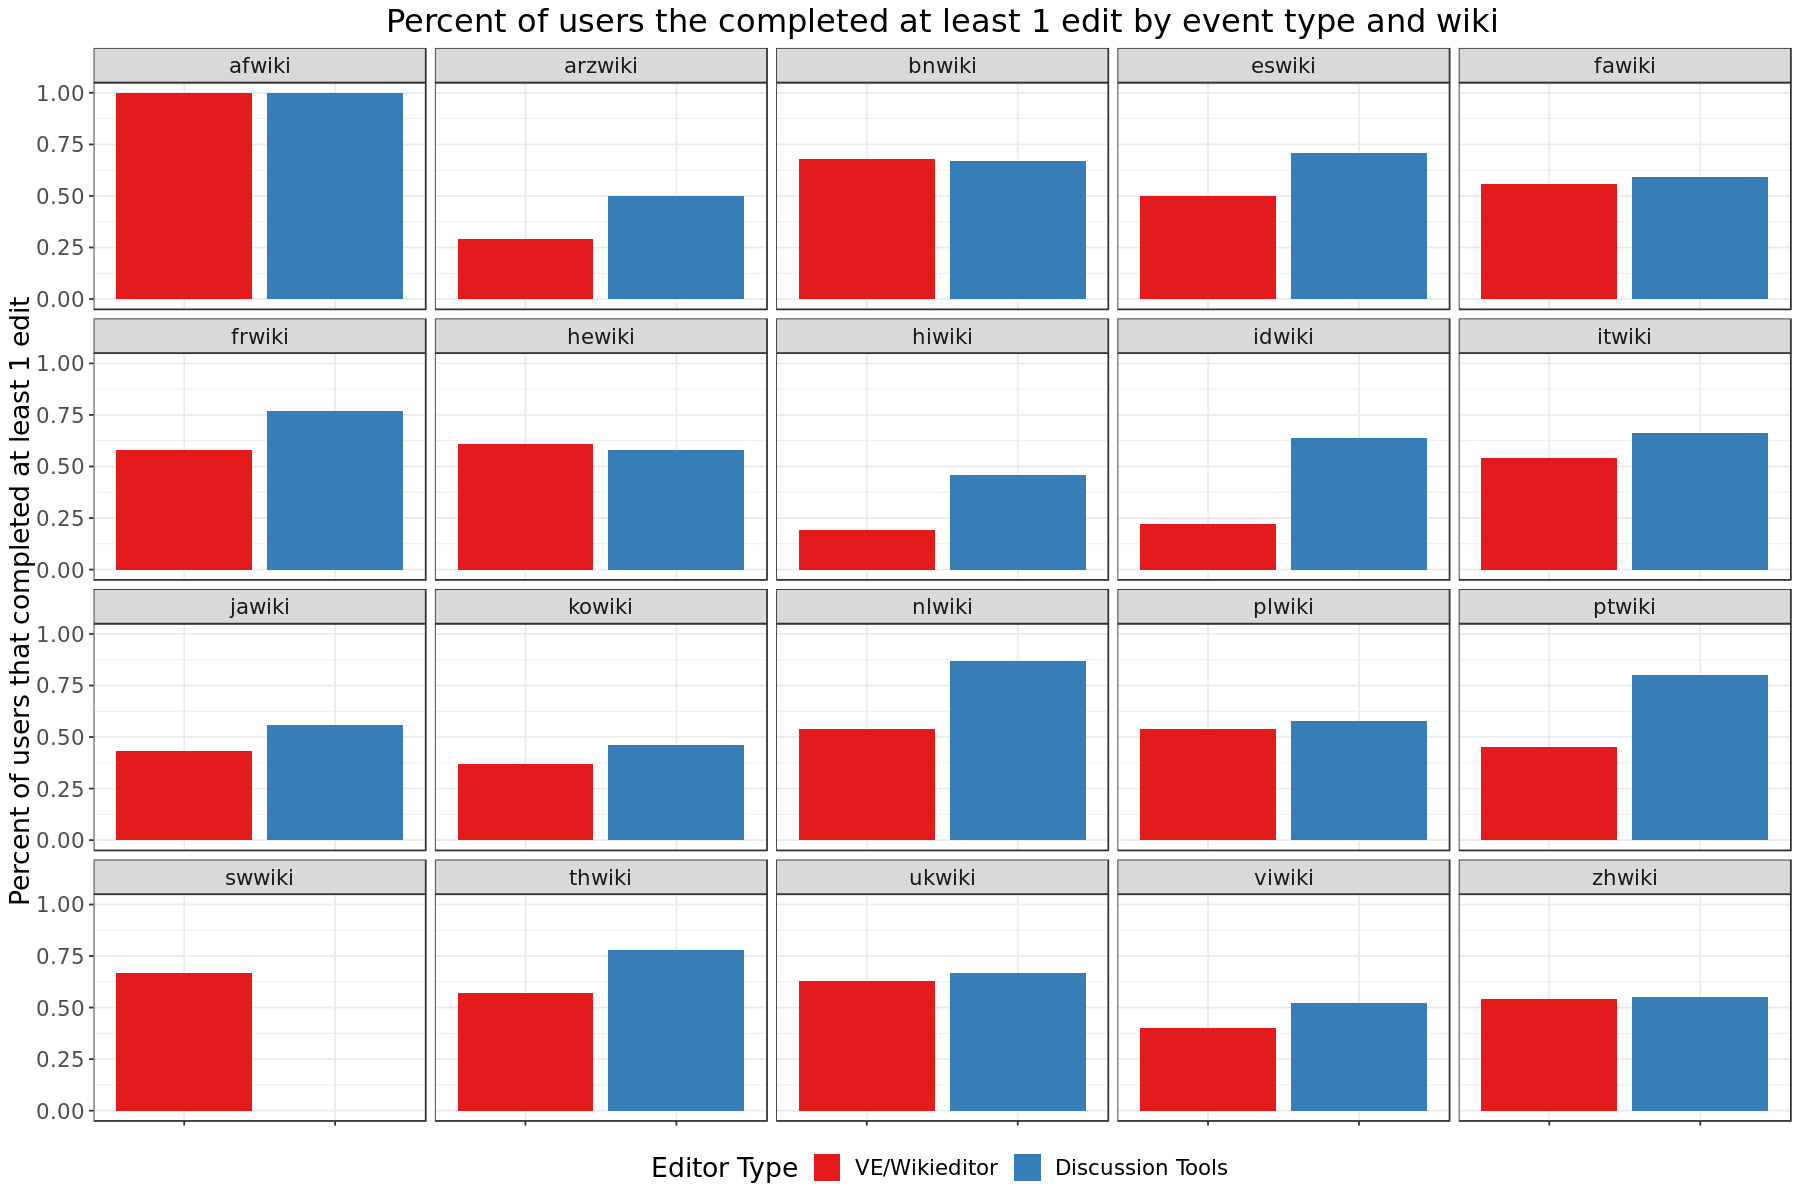

In [19]:
# Plot edit completion rates for each user on each wiki and each 

p <- ab_user_completion_rate_bywiki %>%
    ggplot(aes(x= editor_type, y = completion_rate, fill = editor_type)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki) +
    labs (y = "Percent of users that completed at least 1 edit",
              x = "Editor Type",
             title = "Percent of users the completed at least 1 edit by event type and wiki")  +
        theme_bw() +
        scale_fill_brewer(name="Editor Type", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      

p

# Modeling Impact

We first start with just a standard logistic regression. In this case, we use logistic regression model as the outcome (edit complete or not complete) is a binary variable.

In this model, the binary response is edit_completed and the predictor variable is event_type.

In [20]:
 # use glm or lm here?
mylogit <- glm(edit_completed ~ enabled, data = collect_ab_edit_attempts, family = "binomial")

In [21]:
mylogit


Call:  glm(formula = edit_completed ~ enabled, family = "binomial", 
    data = collect_ab_edit_attempts)

Coefficients:
(Intercept)      enabled  
   -0.53850      0.03535  

Degrees of Freedom: 12980 Total (i.e. Null);  12979 Residual
Null Deviance:	    17140 
Residual Deviance: 17140 	AIC: 17140

In [22]:
confint(mylogit)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-0.5878478,-0.4893614
enabled,-0.0358909,0.1065879


Next we'll run a mixed model to include unique effect for each user. 

In [ ]:
library(lme4)
gpa_mixed = lmer(gpa ~ occasion + (1 | student), data = gpa)

## Scratchpad

## Edit Completion Rate (Defined as number of users that complete at least one edit)

In [100]:
ab_edit_completion_rate_user <- collect_ab_edit_attempts %>%
    group_by (event_type, experiment_group, user_id) %>%
    summarise(n_completions = sum(edit_completed == 'true')) %>%
    ungroup() %>%
    group_by(event_type, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_completed = sum(n_completions >= 1),
             completion_rate = round(n_users_completed/n_users, 2))

ab_edit_completion_rate_user

`summarise()` regrouping output by 'event_type', 'experiment_group' (override with `.groups` argument)

`summarise()` regrouping output by 'event_type' (override with `.groups` argument)



event_type,experiment_group,n_users,n_users_completed,completion_rate
<fct>,<chr>,<int>,<int>,<dbl>
VE/Wikieditor,control,1092,580,0.53
VE/Wikieditor,test,1023,522,0.51
Discussion Tools,control,21,16,0.76
Discussion Tools,test,1681,1149,0.68


## Edit Completion Rate by Wiki (Defined as number of users that complete at least on edit)

In [101]:
ab_edit_completion_rate_user_bywiki <- collect_ab_edit_attempts %>%
    group_by (wiki, event_type, user_id) %>%
    summarise(n_completions = sum(edit_completed == 'true')) %>%
    ungroup()  %>%
    group_by(wiki, event_type) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_completed = sum(n_completions >= 1),
             completion_rate = round(n_users_completed/n_users, 2))

ab_edit_completion_rate_user_bywiki

`summarise()` regrouping output by 'wiki', 'event_type' (override with `.groups` argument)

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,event_type,n_users,n_users_completed,completion_rate
<chr>,<fct>,<int>,<int>,<dbl>
afwiki,VE/Wikieditor,3,3,1.00
afwiki,Discussion Tools,1,1,1.00
arzwiki,VE/Wikieditor,7,2,0.29
arzwiki,Discussion Tools,2,1,0.50
bnwiki,VE/Wikieditor,19,13,0.68
bnwiki,Discussion Tools,12,8,0.67
eswiki,VE/Wikieditor,318,156,0.49
eswiki,Discussion Tools,272,193,0.71
fawiki,VE/Wikieditor,106,59,0.56


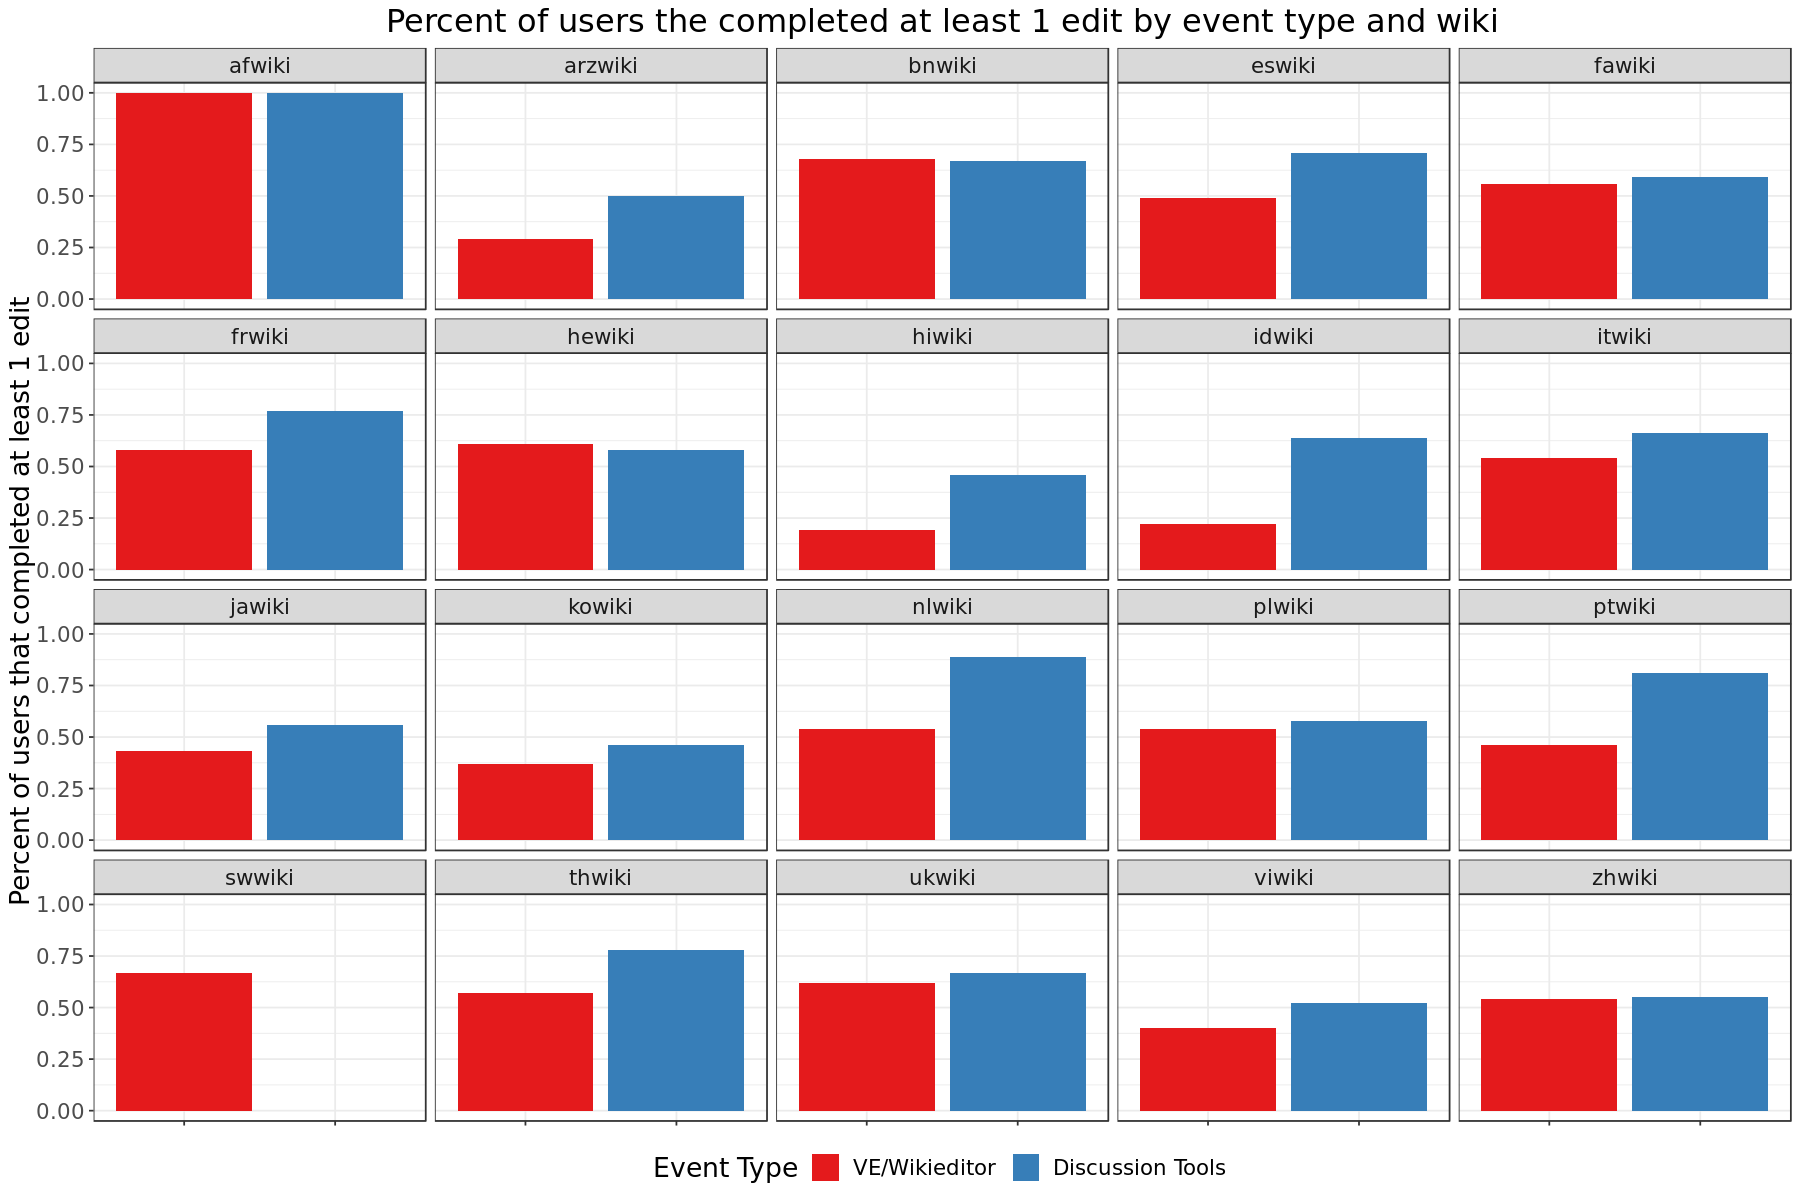

In [103]:
# Plot edit completion rates for each user on each wiki and each 

p <- ab_edit_completion_rate_user_bywiki %>%
    ggplot(aes(x= event_type, y = completion_rate, fill = event_type)) +
    geom_col(position = 'dodge') +
    facet_wrap(~ wiki) +
    labs (y = "Percent of users that completed at least 1 edit",
              x = "Event Type",
             title = "Percent of users the completed at least 1 edit by event type and wiki")  +
        theme_bw() +
        scale_fill_brewer(name="Event Type", palette="Set1")  +
        theme(
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            legend.position = "bottom")
      

p

# Standard Regression Model

In [ ]:
WE start with a standard regression

In [ ]:
user_cr_lm = lm(completion_rate ~ occasion, data = ab_edit_completion_rate_user_bywiki)